# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 14.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 16.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2 (1.5 балла)** Стохастического градиентного спуска;

** Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [140]:
import warnings
warnings.simplefilter("ignore")

In [146]:
sns.set_style('whitegrid')

In [112]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        
        self.w_list = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        
        self.loss_history = []
        
        ell = X.shape[0]
        if X.shape == (ell,):
            X = X.reshape((-1, 1))
        d = X.shape[1]
        
        if self.w0 is None:
            self.w0 = np.zeros(d, dtype=np.float)
        
        self.w = self.w0
        self.loss_history.append(self.calc_loss(X, y))
        
        self.w_list = [(self.w).copy()]
        
        h_inertion = np.zeros(d, dtype=np.float)
        
        for i in range(self.max_iter):
            
            if self.gd_type == 'stochastic':
                batch_size = 1
                sample = np.random.randint(ell, size=batch_size)
                if type(y) == pd.Series:
                    grad = self.calc_gradient(X[sample], y.iloc[sample])
                else:
                    grad = self.calc_gradient(X[sample], y[sample])
            else:
                grad = self.calc_gradient(X, y)
                
            h_k = self.alpha * h_inertion + self.eta * grad
            w_new = self.w - h_k
            
            if self.gd_type == 'momentum':
                h_inertion = h_k
           
            self.loss_history.append(self.calc_loss(X, y))
            self.w_list.append((self.w).copy())
            
            if np.linalg.norm(w_new - self.w, ord=2) <= self.tolerance:
                self.w = w_new
                break
                
            self.w = w_new
        
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        if X.shape == (X.shape[0],):
            X = X.reshape((-1, 1))
            
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        ell = X.shape[0]
        A = np.dot(X, self.w) - y
        grad = 2 / ell * np.dot(X.T, A)
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        # print('X:',X.shape, 'w:', (self.w).shape, 'y:', y.shape)
        loss = np.square(np.dot(X, self.w) - y).mean()
        return loss

Посмотрим, как работает класс, сгенерировав выборку, а затем визуализировав градиентный спуск.

In [113]:
n_features = 2
n_objects = 300
batch_size = 10

w_true = np.random.normal(size=(n_features, ))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Full GD

In [114]:
temp = LinearReg(gd_type='full')

In [115]:
temp.fit(x_train, y_train)

LinearReg(alpha=0.001, eta=0.01, gd_type='full', max_iter=1000,
     tolerance=0.0001, w0=array([0., 0.]))

In [116]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
w_list = np.array(temp.w_list)

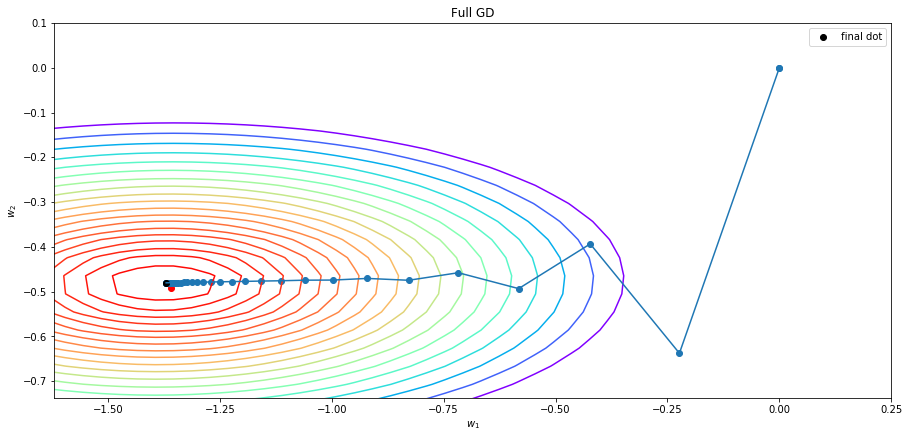

In [117]:
plt.figure(figsize=(15, 20))
plt.title('Full GD')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.25, w_list[:, 0].max() + 0.25))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# levels
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)

# visualize trajectory

plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])
plt.scatter(w_list[-1][0], w_list[-1][1], c='black', label='final dot')
plt.legend()
plt.show()

#### Momentum c alpha=0.5

In [118]:
temp2 = LinearReg(gd_type='momentum', alpha=0.5)

In [119]:
temp2.fit(x_train, y_train)

LinearReg(alpha=0.5, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=array([0., 0.]))

In [121]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
w_list2 = np.array(temp2.w_list)

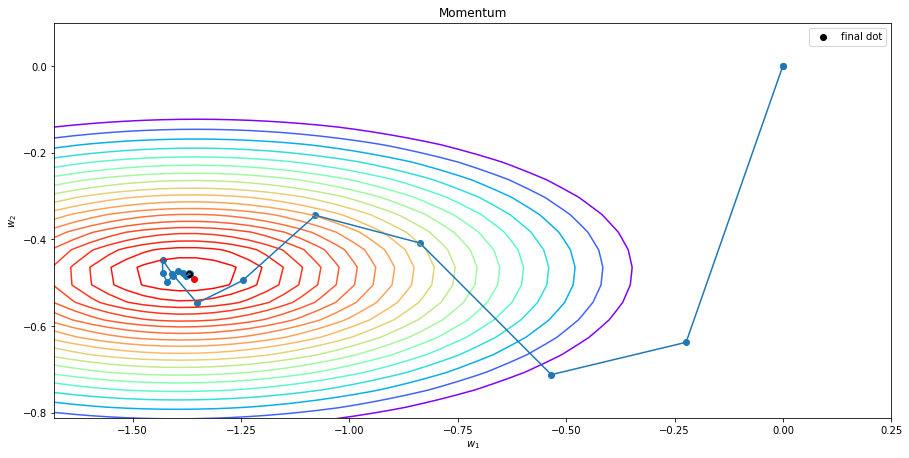

In [122]:
plt.figure(figsize=(15, 20))
plt.title('Momentum')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list2[:, 0].min() - 0.25, w_list2[:, 0].max() + 0.25))
plt.ylim((w_list2[:, 1].min() - 0.1, w_list2[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
#CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list2[:, 0], w_list2[:, 1])
plt.plot(w_list2[:, 0], w_list2[:, 1])
plt.scatter(w_list2[-1][0], w_list2[-1][1], c='black', label='final dot')
plt.legend()
plt.show()

#### Stochastic

In [67]:
temp3 = LinearReg(max_iter=16, gd_type='stochastic')

In [68]:
temp3.fit(x_train, y_train)

LinearReg(alpha=0.001, eta=0.01, gd_type='stochastic', max_iter=16,
     tolerance=0.0001, w0=array([0., 0.]))

In [69]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
w_list = np.array(temp3.w_list)

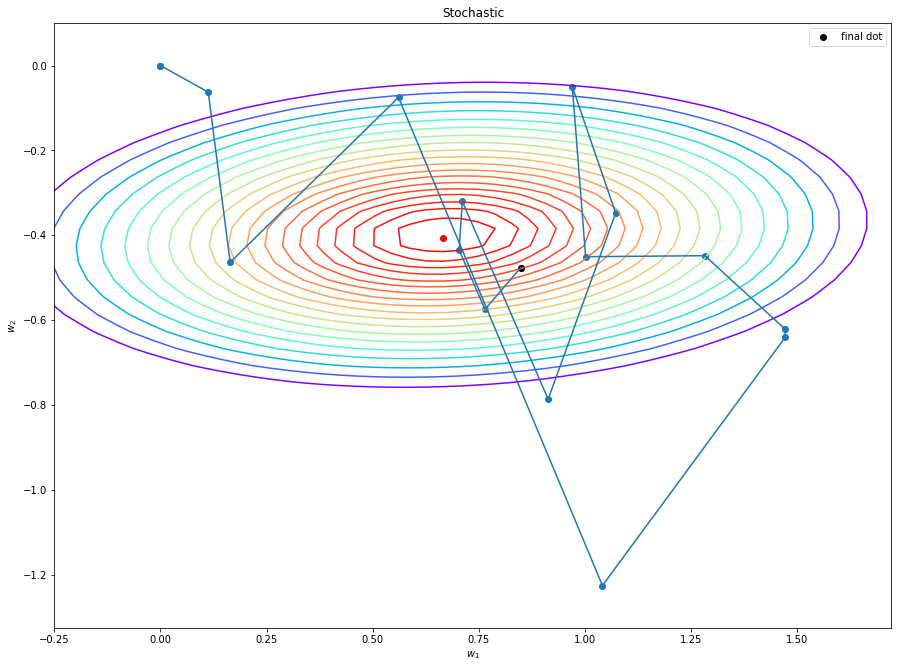

In [72]:
plt.figure(figsize=(15, 20))
plt.title('Stochastic')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.25, w_list[:, 0].max() + 0.25))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
#CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[-1][0], w_list[-1][1], c='black', label='final dot')
plt.legend()
plt.show()

** Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [339]:
data = pd.read_csv("train.csv")

In [340]:
data.loc[:,"trip_duration"] = np.log1p(data['trip_duration'])
data.drop(columns=["dropoff_datetime", 'id'], inplace=True)
data['pickup_datetime'] = data['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d\n%H:%M:%S'))

In [341]:
data['weekday'] = data['pickup_datetime'].apply(lambda x: x.date().weekday())
data['month'] = data['pickup_datetime'].apply(lambda x: x.date().month)
data['hour'] = data['pickup_datetime'].apply(lambda x: x.hour)
data['day_num'] = data['pickup_datetime'].apply(lambda x: x.date().timetuple().tm_yday)
data.drop(columns=['pickup_datetime'], inplace=True)

In [342]:
from haversine import haversine
data['log_haversine'] = np.log1p(data.apply(lambda x: haversine(
    (x['pickup_longitude'], x['pickup_latitude']),
    (x['dropoff_longitude'], x['dropoff_latitude'])
), axis=1))

In [343]:
y = data["trip_duration"]
X = data.drop(columns="trip_duration")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

** Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [129]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = list(X_train.dtypes[X_train.dtypes != "object"].index)

In [130]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

In [131]:
pipeline1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='full'))
])
pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='momentum', alpha=0.5))
])
pipeline3 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='stochastic'))
])

In [137]:
gd_types = ['full', 'momentum', 'stochastic']
pipelines = [pipeline1, pipeline2, pipeline3]

In [141]:
for pipeline, gd in zip(pipelines, gd_types):
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # print(gd, ':')
    print(gd, "Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
    print(gd, "Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
    print(gd, "Test R^2 = %.4f" % r2_score(y_test, y_pred))
    print(gd, "Train R^2 = %.4f" % r2_score(y_train, y_train_pred))

full Test MSE = 0.5129
full Train MSE = 0.5229
full Test R^2 = 0.1855
full Train R^2 = 0.1763
momentum Test MSE = 0.4773
momentum Train MSE = 0.4865
momentum Test R^2 = 0.2419
momentum Train R^2 = 0.2336
stochastic Test MSE = 1.7296
stochastic Train MSE = 1.8725
stochastic Test R^2 = -1.7469
stochastic Train R^2 = -1.9500


Исследуем влияние alpha на процесс оптимизации для momentum

In [484]:
from sklearn.model_selection import GridSearchCV

In [477]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [485]:
from sklearn.metrics import make_scorer

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

mse_scorer = make_scorer(
    mse,
    greater_is_better=False
)

r2_scorer = make_scorer(
    r2,
    greater_is_better=False
)

In [479]:
alphas_momentum1 = [10 ** i for i in range(-4, 0)]
pipeline_alpha_momentum1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='momentum'))
])

In [486]:
alpha_m_searcher = GridSearchCV(pipeline_alpha_momentum1, {'regression__alpha': alphas_momentum1}
                        , scoring=mse_scorer, cv=2)
alpha_m_searcher2 = GridSearchCV(pipeline_alpha_momentum1, {'regression__alpha': alphas_momentum1}
                        , scoring=r2_scorer, cv=2)

In [491]:
alpha_m_searcher.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...inearReg(alpha=0.001, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [487]:
alpha_m_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...inearReg(alpha=0.001, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [495]:
results_ams1 = -alpha_m_searcher.cv_results_['mean_test_score']
results_ams2 = -alpha_m_searcher2.cv_results_['mean_test_score']

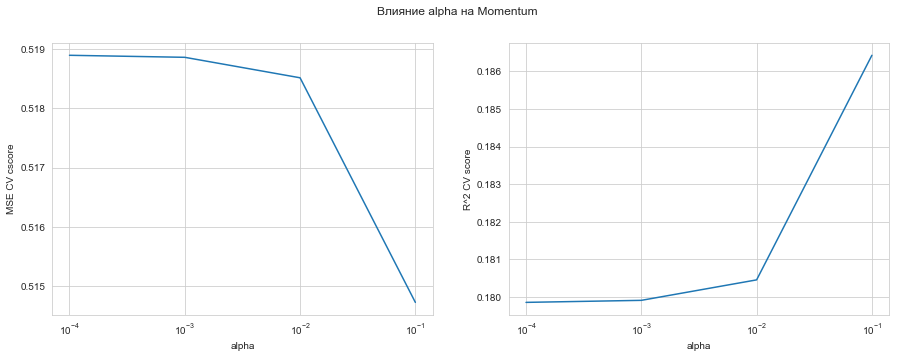

In [507]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].semilogx(alphas_momentum1, results_ams1)
axs[0].set_ylabel('MSE CV cscore')
axs[0].set_xlabel('alpha')

axs[1].semilogx(alphas_momentum1, results_ams2)
axs[1].set_ylabel('R^2 CV score')
axs[1].set_xlabel('alpha')

plt.suptitle('Влияние alpha на Momentum')
plt.show()

Видно, что, чем больше alpha, тем лучше качество по обеим метрикам. Посмотрим, что происходит в интервале (0.9; 1.0)

In [499]:
alphas_momentum2 = [0.9 + 0.01 * i for i in range(0, 10)]
alpha_m2_searcher = GridSearchCV(pipeline_alpha_momentum1, {'regression__alpha': alphas_momentum2}
                        , scoring=mse_scorer, cv=2)
alpha_m2_searcher2 = GridSearchCV(pipeline_alpha_momentum1, {'regression__alpha': alphas_momentum2}
                        , scoring=r2_scorer, cv=2)

In [500]:
alpha_m2_searcher.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...inearReg(alpha=0.001, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': [0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [501]:
alpha_m2_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...inearReg(alpha=0.001, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': [0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [502]:
results2_ams1 = -alpha_m2_searcher.cv_results_['mean_test_score']
results2_ams2 = -alpha_m2_searcher2.cv_results_['mean_test_score']

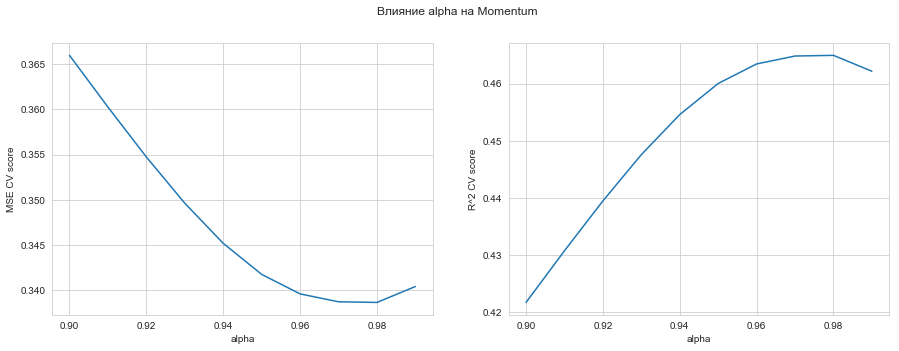

In [508]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(alphas_momentum2, results2_ams1)
axs[0].set_ylabel('MSE CV score')
axs[0].set_xlabel('alpha')

axs[1].plot(alphas_momentum2, results2_ams2)
axs[1].set_ylabel('R^2 CV score')
axs[1].set_xlabel('alpha')

plt.suptitle('Влияние alpha на Momentum')

plt.show()

In [506]:
alpha_m2_searcher.best_params_['regression__alpha']

0.98

Из всех вышепредставленных графиков видно, что лучший результат дает alpha = 0.98, при котором MSE минимально, а R^2 максимально.

##### max_iter

In [509]:
max_iters_full1 = [10 ** i for i in range(2, 7)]
pipeline_mif1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='full', alpha=0.98))
])

In [511]:
pipeline_mif1.get_params().keys()

dict_keys(['memory', 'steps', 'ohe_and_scaling', 'regression', 'ohe_and_scaling__n_jobs', 'ohe_and_scaling__remainder', 'ohe_and_scaling__sparse_threshold', 'ohe_and_scaling__transformer_weights', 'ohe_and_scaling__transformers', 'ohe_and_scaling__ohe', 'ohe_and_scaling__scaling', 'ohe_and_scaling__ohe__categorical_features', 'ohe_and_scaling__ohe__categories', 'ohe_and_scaling__ohe__dtype', 'ohe_and_scaling__ohe__handle_unknown', 'ohe_and_scaling__ohe__n_values', 'ohe_and_scaling__ohe__sparse', 'ohe_and_scaling__scaling__copy', 'ohe_and_scaling__scaling__with_mean', 'ohe_and_scaling__scaling__with_std', 'regression__alpha', 'regression__eta', 'regression__gd_type', 'regression__max_iter', 'regression__tolerance', 'regression__w0'])

In [513]:
mif_searcher1 = GridSearchCV(pipeline_mif1, {'regression__max_iter': max_iters_full1}
                        , scoring=mse_scorer, cv=2)
mif_searcher2 = GridSearchCV(pipeline_mif1, {'regression__max_iter': max_iters_full1}
                        , scoring=r2_scorer, cv=2)

In [514]:
mif_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...n', LinearReg(alpha=0.98, eta=0.01, gd_type='full', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [515]:
mif_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...n', LinearReg(alpha=0.98, eta=0.01, gd_type='full', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [516]:
results_mif_mse = -mif_searcher1.cv_results_['mean_test_score']
results_mif_r2 = -mif_searcher2.cv_results_['mean_test_score']

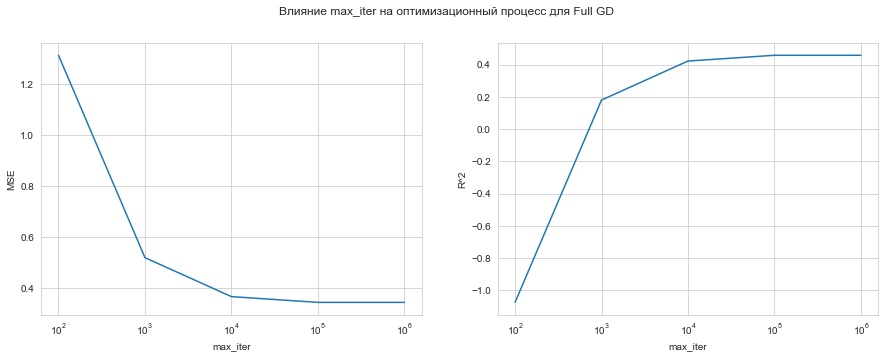

In [517]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(max_iters_full1, results_mif_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('max_iter')

axs[1].semilogx(max_iters_full1, results_mif_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('max_iter')

plt.suptitle('Влияние max_iter на оптимизационный процесс для Full GD')
plt.show()

Для полного градиентного спуска оптимальный параметр max_iter = 10000. До этого значения алгоритм еще не успевает сойтись, а после результаты остаются примерно на одном уровне с результатами для 10^4. Возможно, после достижения данной отметки (в 10000) более высокого числа итераций не достигается, так как разность норм последней пары весов становится меньше значения tolerance, и цикл обрывается не достигнув max_iter>10000.

In [519]:
max_iters_momentum1 = [10 ** i for i in range(2, 7)]
pipeline_mim1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='momentum', alpha=0.98))
])
mim_searcher1 = GridSearchCV(pipeline_mim1, {'regression__max_iter': max_iters_momentum1}
                        , scoring=mse_scorer, cv=2)
mim_searcher2 = GridSearchCV(pipeline_mim1, {'regression__max_iter': max_iters_momentum1}
                        , scoring=r2_scorer, cv=2)

In [520]:
mim_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...LinearReg(alpha=0.98, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [521]:
mim_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...LinearReg(alpha=0.98, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [522]:
results_mim_mse = -mim_searcher1.cv_results_['mean_test_score']
results_mim_r2 = -mim_searcher2.cv_results_['mean_test_score']

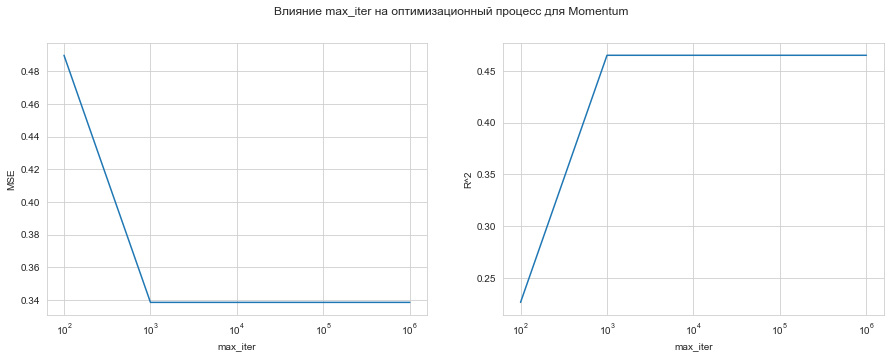

In [523]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(max_iters_momentum1, results_mim_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('max_iter')

axs[1].semilogx(max_iters_momentum1, results_mim_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('max_iter')

plt.suptitle('Влияние max_iter на оптимизационный процесс для Momentum')
plt.show()

In [524]:
max_iters_stochastic1 = [10 ** i for i in range(2, 7)]
pipeline_mis1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='stochastic', alpha=0.98))
])
mis_searcher1 = GridSearchCV(pipeline_mis1, {'regression__max_iter': max_iters_stochastic1}
                        , scoring=mse_scorer, cv=2)
mis_searcher2 = GridSearchCV(pipeline_mis1, {'regression__max_iter': max_iters_stochastic1}
                        , scoring=r2_scorer, cv=2)

In [525]:
mis_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [526]:
mis_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__max_iter': [100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [527]:
results_mis_mse = -mis_searcher1.cv_results_['mean_test_score']
results_mis_r2 = -mis_searcher2.cv_results_['mean_test_score']

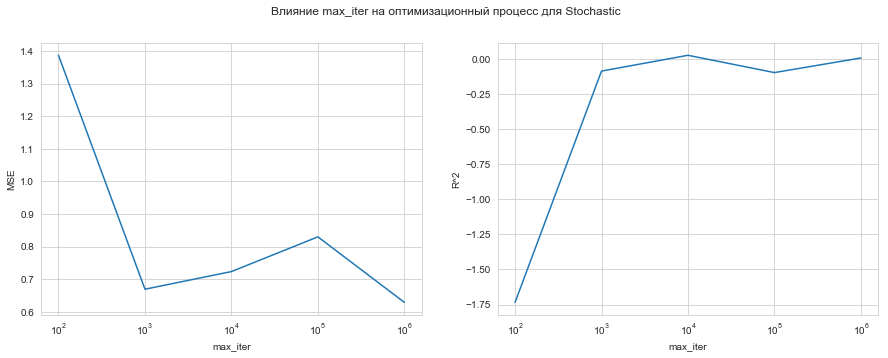

In [532]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(max_iters_stochastic1, results_mis_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('max_iter')

axs[1].semilogx(max_iters_stochastic1, results_mis_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('max_iter')

plt.suptitle('Влияние max_iter на оптимизационный процесс для Stochastic')
plt.show()

In [534]:
full_max_iter = 10**4
momentum_max_iter = 10**3
stochastic_max_iter = 10**3

#### eta

In [535]:
eta_full = [10 ** i for i in range(-3, 0)]
pipeline_ef = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='full', alpha=0.98, max_iter=10**4))
])
ef_searcher1 = GridSearchCV(pipeline_ef, {'regression__eta': eta_full}
                        , scoring=mse_scorer, cv=2)
ef_searcher2 = GridSearchCV(pipeline_ef, {'regression__eta': eta_full}
                        , scoring=r2_scorer, cv=2)

In [536]:
ef_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...', LinearReg(alpha=0.98, eta=0.01, gd_type='full', max_iter=10000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [537]:
ef_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...', LinearReg(alpha=0.98, eta=0.01, gd_type='full', max_iter=10000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [553]:
results_ef_mse = -ef_searcher1.cv_results_['mean_test_score']
results_ef_r2 = -ef_searcher2.cv_results_['mean_test_score']

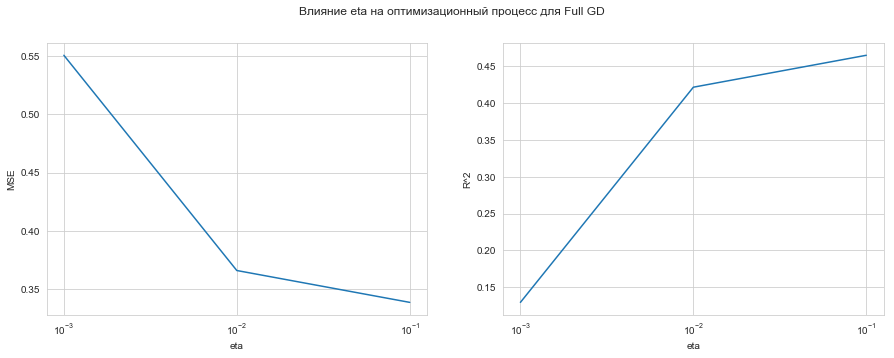

In [554]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(eta_full, results_ef_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('eta')

axs[1].semilogx(eta_full, results_ef_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('eta')

plt.suptitle('Влияние eta на оптимизационный процесс для Full GD')
plt.show()

In [195]:
etas = [0.1 * i for i in range(1, 6)]
MSE_full_eta2 = []
R2_full_eta2 = []

In [207]:
for eta in etas:
    regression = LinearReg(gd_type='full',
                           eta=eta,
                           alpha=0.98,
                           max_iter=full_max_iter)
    model = Pipeline([
        ('ohe_and_scaling', column_transformer),
        ('regression', regression)
    ]).fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    MSE_full_eta2.append(mean_squared_error(y_test, y_pred))
    R2_full_eta2.append(r2_score(y_test, y_pred))

KeyboardInterrupt: 

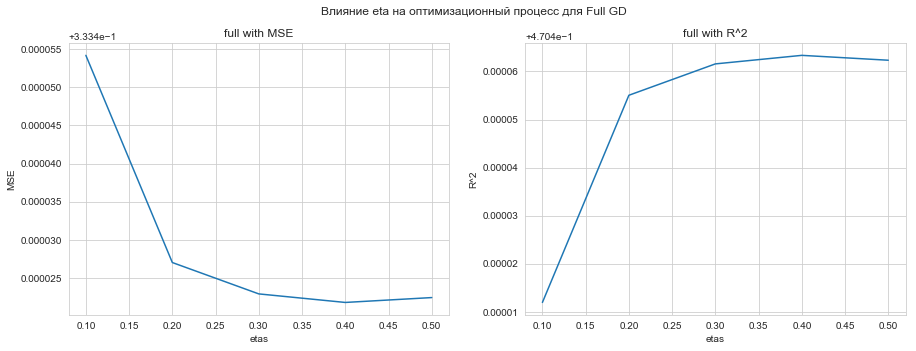

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(etas, MSE_full_eta2)
axs[0].set_title('full with MSE')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('etas')

axs[1].plot(etas, R2_full_eta2)
axs[1].set_title('full with R^2')
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('etas')

plt.suptitle('Влияние eta на оптимизационный процесс для Full GD')
plt.show()

In [202]:
etas[np.argmin(MSE_full_eta2)]

0.4

In [203]:
etas[np.argmax(R2_full_eta2)]

0.4

Таким образом, оптимальным eta для full gd будет являться eta=0.4

In [562]:
eta_momentum = [10 ** i for i in range(-3, 0)]
pipeline_em = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='momentum', alpha=0.98, max_iter=10**3))
])
em_searcher1 = GridSearchCV(pipeline_em, {'regression__eta': eta_momentum}
                        , scoring=mse_scorer, cv=2)
em_searcher2 = GridSearchCV(pipeline_em, {'regression__eta': eta_momentum}
                        , scoring=r2_scorer, cv=2)

In [563]:
em_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...LinearReg(alpha=0.98, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [564]:
em_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...LinearReg(alpha=0.98, eta=0.01, gd_type='momentum', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [565]:
results_em_mse = -em_searcher1.cv_results_['mean_test_score']
results_em_r2 = -em_searcher2.cv_results_['mean_test_score']

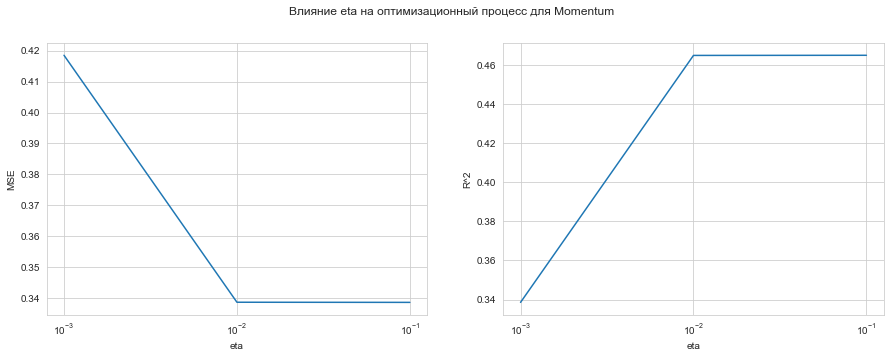

In [566]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(eta_momentum, results_em_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('eta')

axs[1].semilogx(eta_momentum, results_em_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('eta')

plt.suptitle('Влияние eta на оптимизационный процесс для Momentum')
plt.show()

Оптимальная для momentum eta=0.01

In [567]:
eta_st = [10 ** i for i in range(-3, 0)]
pipeline_es = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='stochastic', alpha=0.98, max_iter=10**3))
])
es_searcher1 = GridSearchCV(pipeline_es, {'regression__eta': eta_st}
                        , scoring=mse_scorer, cv=2)
es_searcher2 = GridSearchCV(pipeline_es, {'regression__eta': eta_st}
                        , scoring=r2_scorer, cv=2)

In [568]:
es_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [569]:
es_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [570]:
results_es_mse = -es_searcher1.cv_results_['mean_test_score']
results_es_r2 = -es_searcher2.cv_results_['mean_test_score']

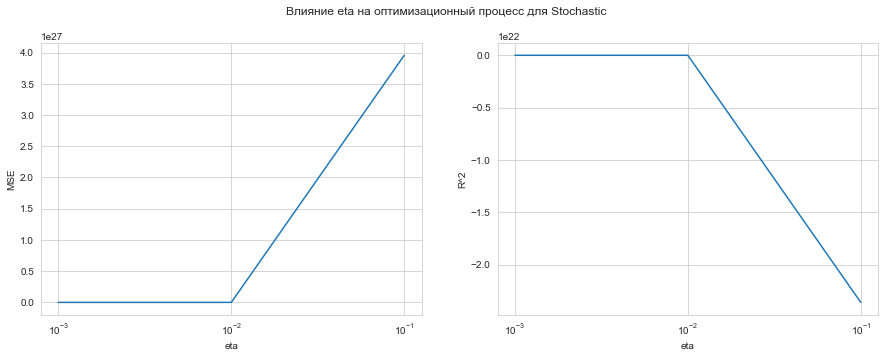

In [572]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(eta_st, results_es_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('eta')

axs[1].semilogx(eta_st, results_es_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('eta')

plt.suptitle('Влияние eta на оптимизационный процесс для Stochastic')
plt.show()

Рассмотрим подробнее отрезок [0.001; 0.01]

In [579]:
eta_st2 = [0.001 * i for i in range(1, 11)]
es2_searcher1 = GridSearchCV(pipeline_es, {'regression__eta': eta_st2}
                        , scoring=mse_scorer, cv=5)
es2_searcher2 = GridSearchCV(pipeline_es, {'regression__eta': eta_st2}
                        , scoring=r2_scorer, cv=5)

In [580]:
es2_searcher1.fit(X_valid, y_valid)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [581]:
es2_searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...nearReg(alpha=0.98, eta=0.01, gd_type='stochastic', max_iter=1000,
     tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__eta': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2, greater_is_better=False), verbose=0)

In [582]:
results_es2_mse = -es2_searcher1.cv_results_['mean_test_score']
results_es2_r2 = -es2_searcher2.cv_results_['mean_test_score']

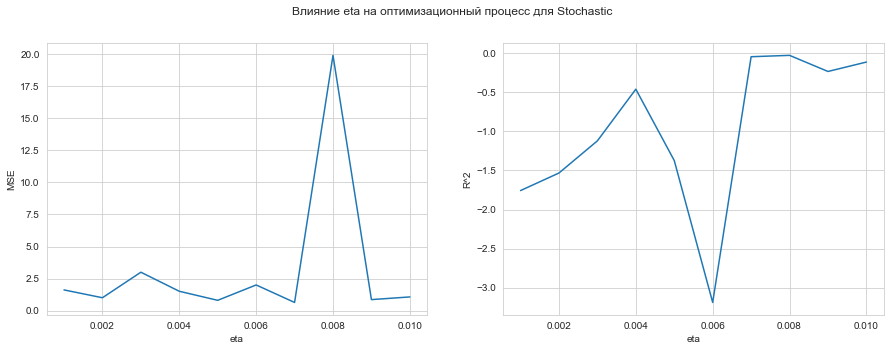

In [583]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(eta_st2, results_es2_mse)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('eta')

axs[1].plot(eta_st2, results_es2_r2)
axs[1].set_ylabel('R^2')
axs[1].set_xlabel('eta')

plt.suptitle('Влияние eta на оптимизационный процесс для Stochastic')
plt.show()

** Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [587]:
pipeline_full = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='full', max_iter=10**6, eta=0.4))
])
pipeline_stochastic = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='stochastic', max_iter=10**6, eta=0.007))
])
pipeline_momentum = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearReg(gd_type='momentum', max_iter=10**6, alpha=0.98, eta=0.01))
])

In [588]:
model_full = pipeline_full.fit(X_train, y_train)
y_predict_full = model_full.predict(X_test)

model_stochastic = pipeline_stochastic.fit(X_train, y_train)
y_predict_stochastic = model_stochastic.predict(X_test)

model_momentum = pipeline_momentum.fit(X_train, y_train)
y_predict_momentum = model_momentum.predict(X_test)

In [589]:
loss_full = model_full.steps[-1][-1].loss_history
loss_stochastic = model_stochastic.steps[-1][-1].loss_history
loss_momentum = model_momentum.steps[-1][-1].loss_history

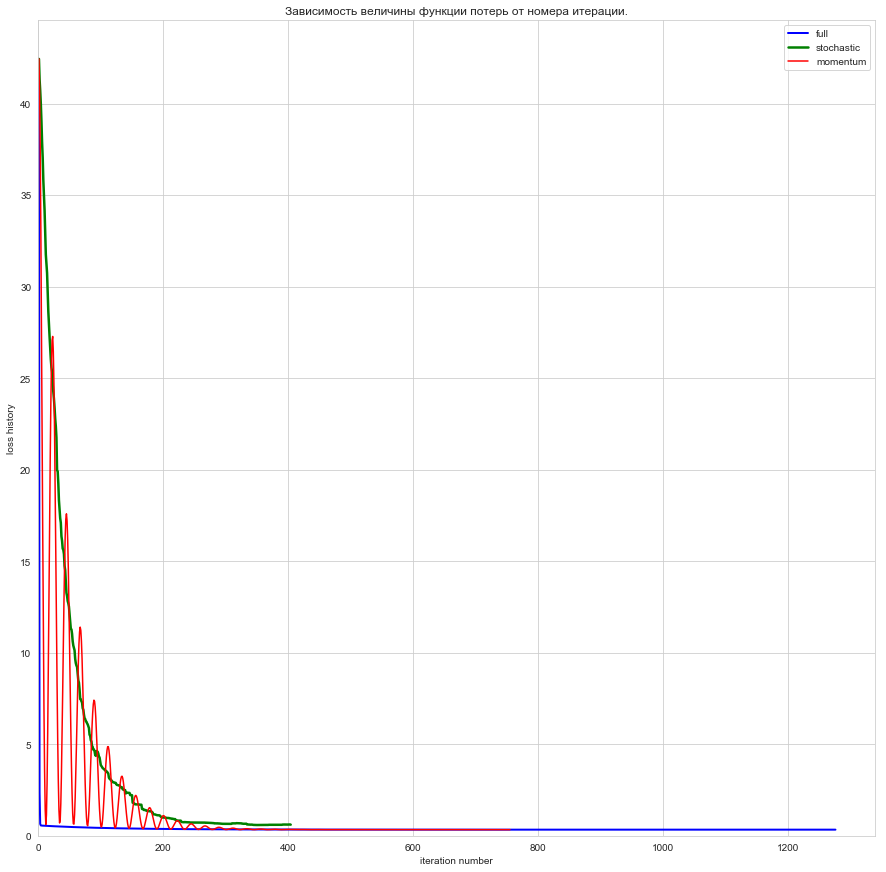

In [590]:
plt.figure(figsize=(15, 15))
plt.plot(range(len(loss_full)), loss_full, linewidth=2, c='b', label='full')
plt.xlim(0, )
plt.ylim(0, )
plt.plot(range(len(loss_stochastic)), loss_stochastic, c='g', linewidth=2.5, label='stochastic')
plt.plot(range(len(loss_momentum)), loss_momentum, c='r', label='momentum')
plt.xlabel('iteration number')
plt.ylabel('loss history')
plt.title('Зависимость величины функции потерь от номера итерации.')
plt.legend()
plt.show()

In [591]:
print("full \t\t MSE = %.4f" % mean_squared_error(y_test, y_predict_full))
print("stochastic \t MSE = %.4f" % mean_squared_error(y_test, y_predict_stochastic))
print("momentum \t MSE = %.4f" % mean_squared_error(y_test, y_predict_momentum))
print("full \t\t R^2 = %.4f" % r2_score(y_test, y_predict_full))
print("stochastic \t R^2 = %.4f" % r2_score(y_test, y_predict_stochastic))
print("momentum \t R^2 = %.4f" % r2_score(y_test, y_predict_momentum))

full 		 MSE = 0.3278
stochastic 	 MSE = 0.5881
momentum 	 MSE = 0.3278
full 		 R^2 = 0.4794
stochastic 	 R^2 = 0.0661
momentum 	 R^2 = 0.4794


Из построенного графика видно, что быстрее всего сходится stochastic, но вместе с тем его результаты хуже результатов, полученных с помощью full gd и momentum. Сравнивая последние, можно заметить, что они дают одинаковую ошибку по обеим метрикам, но momentum сходится быстрее full gd.

### Бонус 

** Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

In [291]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearRegAdam(BaseEstimator):
    def __init__(self, tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3,
                beta1=0.9, beta2=0.9999, eps=1e-8):
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.loss_history = None 
        self.w_list = None
    
    def fit(self, X, y):
        self.loss_history = []
        
        ell = X.shape[0]
        if X.shape == (ell,):
            X = X.reshape((-1, 1))
        d = X.shape[1]
        
        if self.w0 is None:
            self.w0 = np.zeros(d, dtype=np.float)
        
        self.w = self.w0
        self.loss_history.append(self.calc_loss(X, y))
        
        self.w_list = [(self.w).copy()]
        
        m = np.zeros(d, dtype=np.float)
        v = np.zeros(d, dtype=np.float)
        
        for i in range(self.max_iter):
            
            grad = self.calc_gradient(X, y)
            
            m = self.beta1 * m + (1 - self.beta1) * grad
            v = self.beta2 * v + (1 - self.beta2) * np.square(grad)
            
            m_hat = m / (1 - (self.beta1 ** (i + 1)))
            v_hat = v / (1 - (self.beta2 ** (i + 1)))
            
            tmp = self.alpha * (m_hat / (v_hat ** 0.5 + self.eps))
            w_new = self.w - tmp
            
            self.loss_history.append(self.calc_loss(X, y))
            self.w_list.append((self.w).copy())
            
            if np.linalg.norm(w_new - self.w, ord=2) <= self.tolerance:
                self.w = w_new
                break
                
            self.w = w_new
        
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        if X.shape == (X.shape[0],):
            X = X.reshape((-1, 1))
            
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        ell = X.shape[0]
        A = np.dot(X, self.w) - y
        grad = 2 / ell * np.dot(X.T, A)
        return grad

    def calc_loss(self, X, y):
        loss = np.square(np.dot(X, self.w) - y).mean()
        return loss

In [292]:
n_features = 2
n_objects = 300
batch_size = 10

w_true = np.random.normal(size=(n_features, ))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
x_train_, x_test_, y_train_, y_test_ = train_test_split(X, Y, test_size=0.2, random_state=42)

In [331]:
temp3 = LinearRegAdam(max_iter=10**4)
temp3.fit(x_train_, y_train_)

LinearRegAdam(alpha=0.001, beta1=0.9, beta2=0.9999, eps=1e-08, max_iter=10000,
       tolerance=0.0001, w0=array([0., 0.]))

In [332]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
w_list = np.array(temp3.w_list)

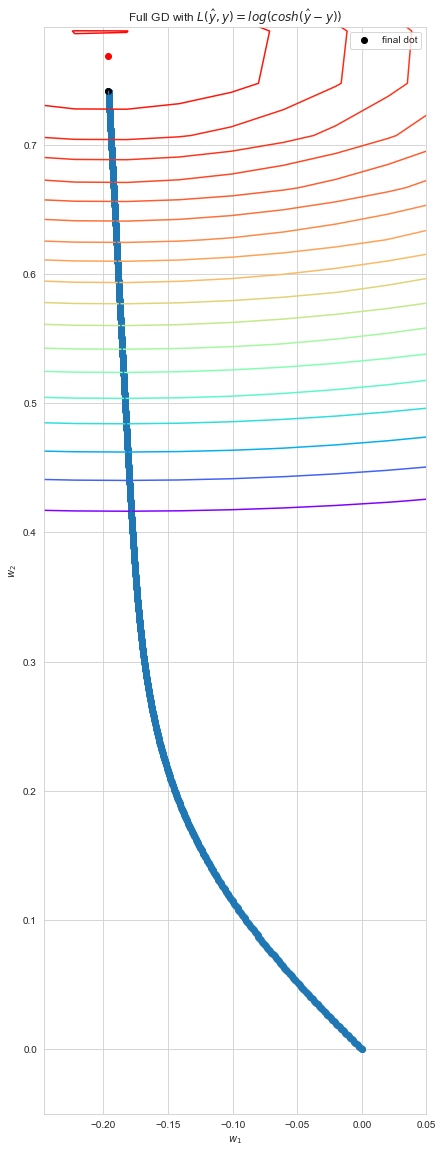

In [333]:
plt.figure(figsize=(15, 20))
plt.title('Full GD with $ L(\hat{y}, y) = log(cosh(\hat{y} - y))$')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.05, w_list[:, 0].max() + 0.05))
plt.ylim((w_list[:, 1].min() - 0.05, w_list[:, 1].max() + 0.05))
plt.gca().set_aspect('equal')

# levels
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)

# visualize trajectory

plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])
plt.scatter(w_list[-1][0], w_list[-1][1], c='black', label='final dot')
plt.legend()
plt.show()

In [334]:
pipelineAdam = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam(max_iter=10**4))
])

In [344]:
modelA = pipelineAdam.fit(X_train, y_train)
y_predA = modelA.predict(X_test)

In [345]:
print("MSE = %.4f" % mean_squared_error(y_test, y_predA))
print("R^2 = %.4f" % r2_score(y_test, y_predA))

MSE = 0.6766
R^2 = -0.0746


In [346]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [348]:
pipelineAdam2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam())
])

In [366]:
pipelineAdam.get_params().keys()

dict_keys(['memory', 'steps', 'ohe_and_scaling', 'regression', 'ohe_and_scaling__n_jobs', 'ohe_and_scaling__remainder', 'ohe_and_scaling__sparse_threshold', 'ohe_and_scaling__transformer_weights', 'ohe_and_scaling__transformers', 'ohe_and_scaling__ohe', 'ohe_and_scaling__scaling', 'ohe_and_scaling__ohe__categorical_features', 'ohe_and_scaling__ohe__categories', 'ohe_and_scaling__ohe__dtype', 'ohe_and_scaling__ohe__handle_unknown', 'ohe_and_scaling__ohe__n_values', 'ohe_and_scaling__ohe__sparse', 'ohe_and_scaling__scaling__copy', 'ohe_and_scaling__scaling__with_mean', 'ohe_and_scaling__scaling__with_std', 'regression__alpha', 'regression__beta1', 'regression__beta2', 'regression__eps', 'regression__max_iter', 'regression__tolerance', 'regression__w0'])

In [376]:
alphas = np.logspace(-4, 0, 5)
max_iters = np.array([10 ** i for i in range(2, 7)])

In [377]:
from sklearn.metrics import make_scorer

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

mse_scorer = make_scorer(
    mse,
    greater_is_better=False
)

In [378]:
searcher = GridSearchCV(pipelineAdam2, {'regression__alpha': alphas,
                                        'regression__max_iter': max_iters}
                        , scoring=mse_scorer, cv=2)

In [379]:
searcher.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...(alpha=0.001, beta1=0.9, beta2=0.9999, eps=1e-08, max_iter=1000,
       tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]), 'regression__max_iter': array([    100,    1000,   10000,  100000, 1000000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [382]:
searcher.best_params_

{'regression__alpha': 1.0, 'regression__max_iter': 1000}

In [410]:
results_alpha = []
for i in range(1, 25, 5):
    results_alpha.append(searcher.cv_results_['mean_test_score'][i])
results_alpha = np.array(results_alpha)

In [407]:
searcher.cv_results_

{'mean_fit_time': array([  0.50176036,   5.56330776,  58.13466072, 295.85836005,
        225.47508359,   0.48641384,   4.22494912,  41.03087831,
         53.97338879,  53.87530077,   0.47380888,   4.09211373,
          7.9404974 ,   7.94009984,   7.95512366,   0.47182965,
          0.71016097,   0.71015215,   0.71263325,   0.71325302,
          0.47219002,   0.85406911,   0.85003221,   0.85183382,
          0.85141551]),
 'std_fit_time': array([1.57655478e-02, 9.10713196e-01, 6.35761023e-01, 8.87205672e+00,
        1.13175740e+01, 1.86240673e-03, 1.39999390e-03, 5.72877645e-01,
        8.13964605e-02, 2.61201024e-01, 1.03294849e-03, 2.42328644e-03,
        1.51286125e-02, 1.94569826e-02, 7.74145126e-04, 1.65319443e-03,
        3.58295441e-03, 2.51984596e-03, 8.99195671e-04, 2.37178802e-03,
        1.55413151e-03, 8.10980797e-04, 7.33137131e-05, 1.19924545e-04,
        9.43779945e-04]),
 'mean_score_time': array([0.0436691 , 0.05223393, 0.04861093, 0.03808212, 0.03612936,
        0.0392

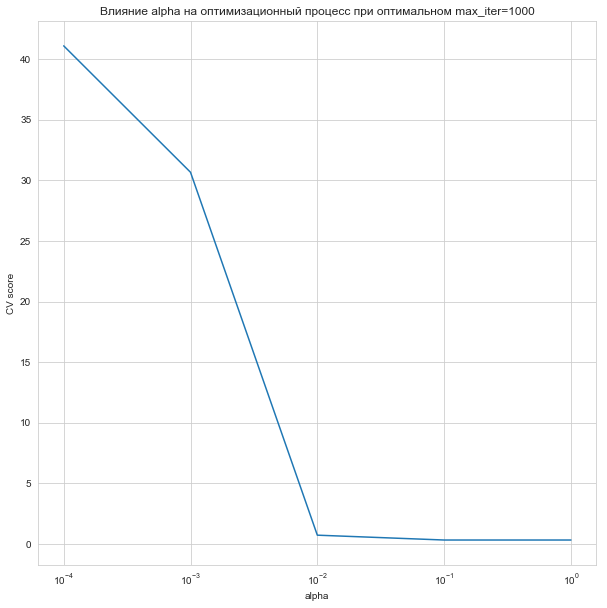

In [411]:
plt.figure(figsize=(10, 10))
plt.plot(alphas, -results_alpha)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Влияние alpha на оптимизационный процесс при оптимальном max_iter=1000")
plt.show()

In [419]:
results_iter1 = []
for i in range(20, 25):
    results_iter1.append(searcher.cv_results_['mean_test_score'][i])
results_iter1 = np.array(results_iter1)

results_iter2 = []
for i in range(10, 15):
    results_iter2.append(searcher.cv_results_['mean_test_score'][i])
results_iter2 = np.array(results_iter2)

In [426]:
results_iter1

array([-0.32704705, -0.32683264, -0.32683264, -0.32683264, -0.32683264])

In [427]:
results_iter2

array([-30.54797508,  -0.72673821,  -0.32707075,  -0.32707075,
        -0.32707075])

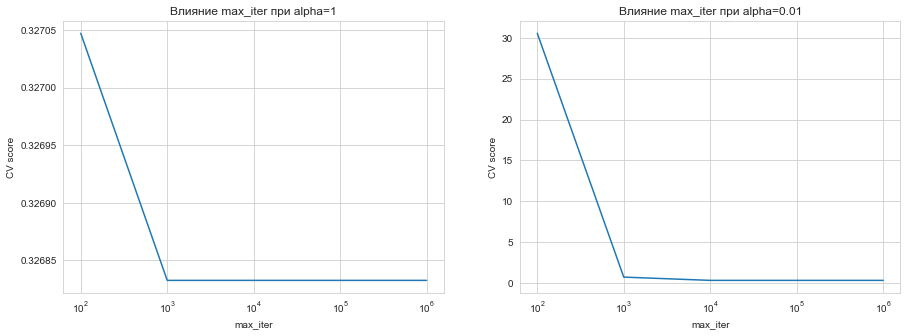

In [425]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].semilogx(max_iters, -results_iter1)
axs[0].set_title('Влияние max_iter при alpha=1')
axs[0].set_ylabel('CV score')
axs[0].set_xlabel('max_iter')

axs[1].semilogx(max_iters, -results_iter2)
axs[1].set_title('Влияние max_iter при alpha=0.01')
axs[1].set_ylabel('CV score')
axs[1].set_xlabel('max_iter')

plt.show()

Рассмотрим ближе участок alpha близкий к 1

In [429]:
alphas2 = [0.9 + 0.01 * i for i in range(0, 10)]

In [431]:
searcher2 = GridSearchCV(pipelineAdam2, {'regression__alpha': alphas2}, scoring=mse_scorer, cv=2)

In [432]:
searcher2.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...(alpha=0.001, beta1=0.9, beta2=0.9999, eps=1e-08, max_iter=1000,
       tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__alpha': [0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

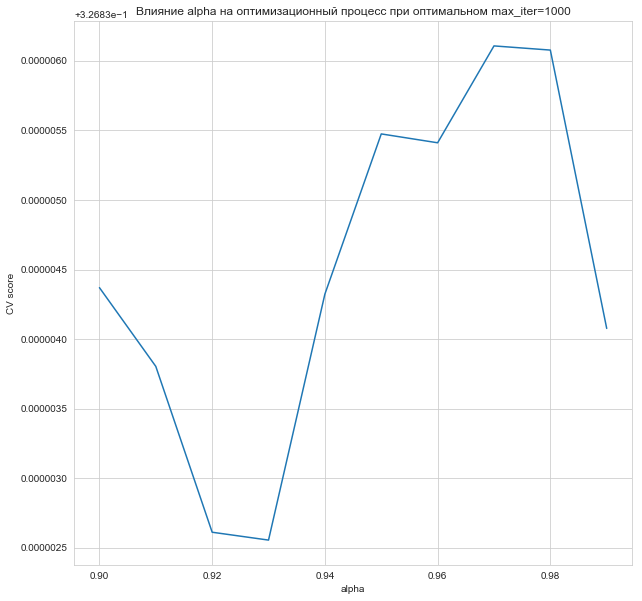

In [434]:
plt.figure(figsize=(10, 10))
plt.plot(alphas2, -searcher2.cv_results_['mean_test_score'])
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Влияние alpha на оптимизационный процесс при оптимальном max_iter=1000")
plt.show()

In [438]:
searcher2.best_params_['regression__alpha']

0.93

Получаем оптимальные alpha=0.93 и max_iter=1000. Теперь для beta1, beta2.

In [443]:
beta1s = np.array([0.1 * i for i in range(5, 10)])
beta2s = np.array([0.1 * i for i in range(5, 10)])

In [444]:
pipelineAdam3 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam(alpha=0.93))
])

searcher3 = GridSearchCV(pipelineAdam3, {'regression__beta1': beta1s,
                                        'regression__beta2': beta2s}
                        , scoring=mse_scorer, cv=2)

In [445]:
searcher3.fit(X_valid, y_valid)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe_and_scaling', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values...m(alpha=0.93, beta1=0.9, beta2=0.9999, eps=1e-08, max_iter=1000,
       tolerance=0.0001, w0=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regression__beta1': array([0.5, 0.6, 0.7, 0.8, 0.9]), 'regression__beta2': array([0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mse, greater_is_better=False), verbose=0)

In [446]:
searcher3.best_params_

{'regression__beta1': 0.9, 'regression__beta2': 0.7000000000000001}

In [456]:
results_beta1 = []
for i in range(2, 27, 5):
    results_beta1.append(searcher3.cv_results_['mean_test_score'][i])
results_beta1 = np.array(results_beta1)

results_beta2 = []
for i in range(20, 25):
    results_beta2.append(searcher3.cv_results_['mean_test_score'][i])
results_beta2 = np.array(results_beta2)

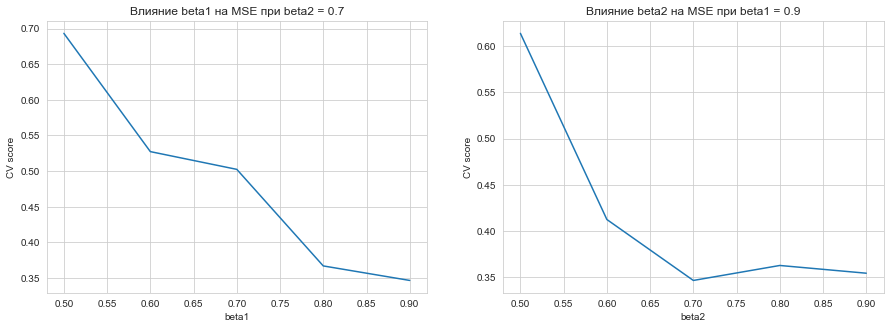

In [460]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta1s, -results_beta1)
axs[0].set_title('Влияние beta1 на MSE при beta2 = 0.7')
axs[0].set_ylabel('CV score')
axs[0].set_xlabel('beta1')

axs[1].plot(beta2s, -results_beta2)
axs[1].set_title('Влияние beta2 на MSE при beta1 = 0.9')
axs[1].set_ylabel('CV score')
axs[1].set_xlabel('beta2')

plt.show()

Таким образом, оптимальные параметры для LinRegAdam: alpha=0.93, max_iter=1000, beta1 = 0.9, beta2 = 0.7

In [471]:
pipelineAdam_final = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegAdam(alpha=0.93, beta1=0.9, beta2=0.7))
])

In [472]:
modelAdam_final = pipelineAdam_final.fit(X_train, y_train)
y_predAdam_final = modelAdam_final.predict(X_test)

In [473]:
lossAdam_final = modelAdam_final.steps[-1][-1].loss_history

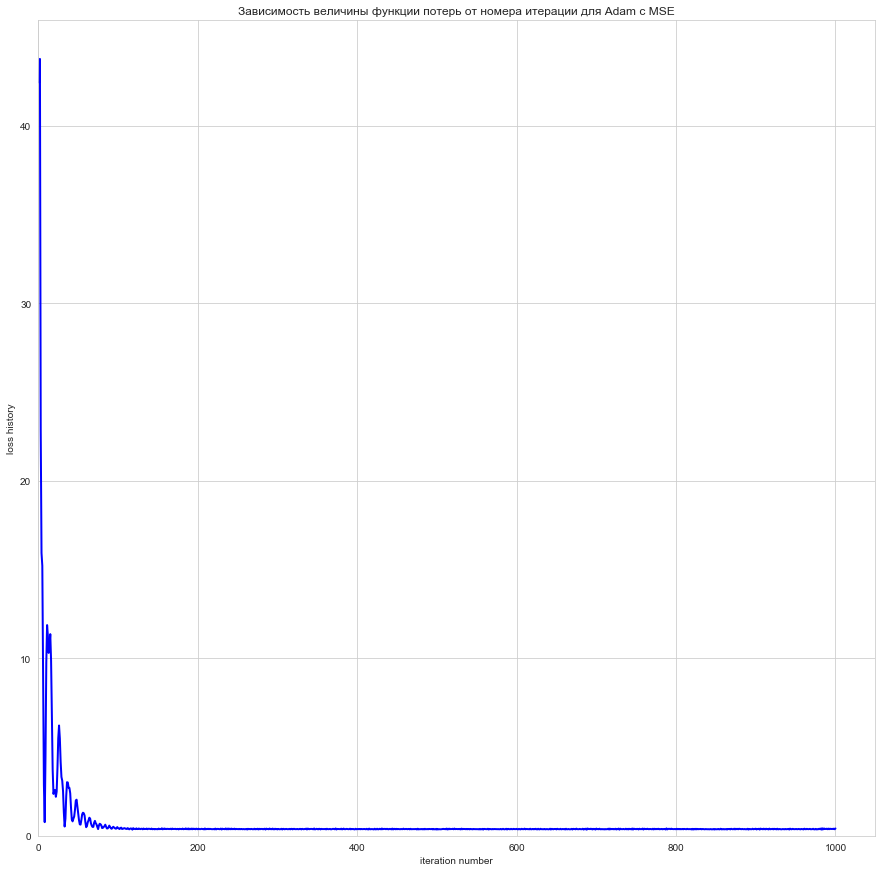

In [476]:
plt.figure(figsize=(15, 15))
plt.plot(range(len(lossAdam_final)), lossAdam_final, linewidth=2, c='b')
plt.xlim(0, )
plt.ylim(0, )
plt.xlabel('iteration number')
plt.ylabel('loss history')
plt.title('Зависимость величины функции потерь от номера итерации для Adam с MSE')
plt.show()

In [600]:
print("MSE = %.4f" % mean_squared_error(y_test, y_predAdam_final))
print("R^2 = %.4f" % r2_score(y_test, y_predAdam_final))

MSE = 0.3596
R^2 = 0.4290


** Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

Функционал качества имеет вид:
$$Q(a, y) = \frac{1}{l}\sum_{i=1}^{l}{L(a(x_i), y_i)} = \frac{1}{l}\sum_{i=1}^{l} log(cosh(a(x_i) - y_i))$$
Тогда градиент $$\nabla_{w}Q(w) = \frac{1}{l}X^{T}tanh(Xw - y)$$

Так как $$\frac{\partial Q}{\partial w_j} = \frac{1}{l} \sum_{i=1}^{l}[tanh(<w, x_i> - y_i) \cdot x_{i}^{j}]$$ где $x_{i}^{j} - $ j-й признак i-го объекта.

In [264]:
class LinearReg2(BaseEstimator):
    def __init__(self, gd_type='full', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        
        self.w_list = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        
        self.loss_history = []
        
        ell = X.shape[0]
        if X.shape == (ell,):
            X = X.reshape((-1, 1))
        d = X.shape[1]
        
        if self.w0 is None:
            self.w0 = np.zeros(d, dtype=np.float)
        
        self.w = self.w0
        self.loss_history.append(self.calc_loss(X, y))
        
        self.w_list = [(self.w).copy()]
        
        h_inertion = np.zeros(d, dtype=np.float)
        
        for i in range(self.max_iter):
            
            grad = self.calc_gradient(X, y)
            w_new = self.w - self.eta * grad
            
            self.loss_history.append(self.calc_loss(X, y))
            self.w_list.append((self.w).copy())
            
            if np.linalg.norm(w_new - self.w, ord=2) <= self.tolerance:
                self.w = w_new
                break
                
            self.w = w_new
        
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        if X.shape == (X.shape[0],):
            X = X.reshape((-1, 1))
            
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        ell = X.shape[0]
        A = np.dot(X, self.w) - y
        grad = np.dot(X.T, np.tanh(A)) / ell
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        loss = np.log(np.cosh(np.dot(X, self.w) - y)).mean()
        return loss

In [265]:
n_features = 2
n_objects = 300
batch_size = 10

w_true = np.random.normal(size=(n_features, ))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [273]:
temp = LinearReg2(gd_type='full')
temp.fit(x_train, y_train)

LinearReg2(eta=0.01, gd_type='full', max_iter=1000, tolerance=0.0001,
      w0=array([0., 0.]))

In [274]:
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
w_list = np.array(temp.w_list)

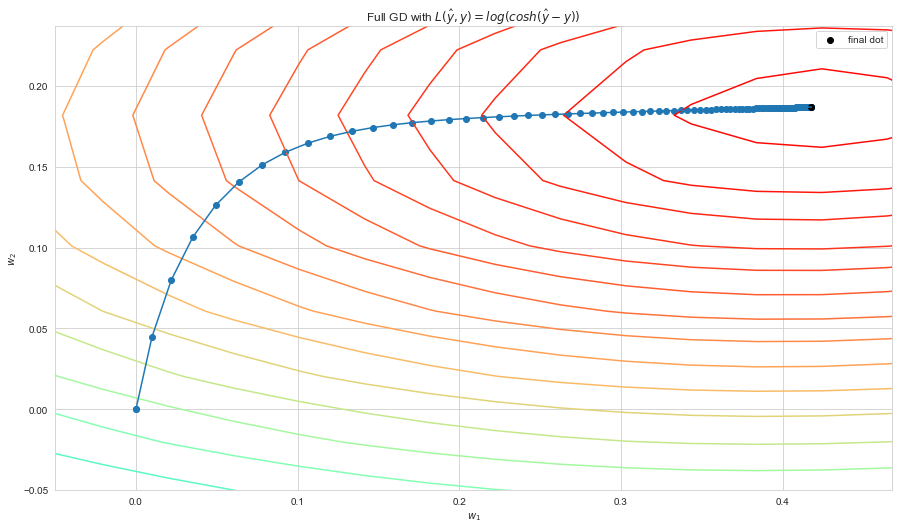

In [284]:
plt.figure(figsize=(15, 20))
plt.title('Full GD with $ L(\hat{y}, y) = log(cosh(\hat{y} - y))$')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.05, w_list[:, 0].max() + 0.05))
plt.ylim((w_list[:, 1].min() - 0.05, w_list[:, 1].max() + 0.05))
plt.gca().set_aspect('equal')

# levels
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)

# visualize trajectory

plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])
plt.scatter(w_list[-1][0], w_list[-1][1], c='black', label='final dot')
plt.legend()
plt.show()

** Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook

<img src="https://www.dropbox.com/s/llggvcijzd6m0u4/cOAecre2kxo.jpg?raw=1">